## Polygon AutoEncoder

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_fixedsize

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        
        # Compute the positional encodings in advance
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:, :-1] # Avoid dismatch dimension for odd d_model
        pe = pe.unsqueeze(0).transpose(0, 1)  # Add batch dimension and transpose
        
        # Register the positional encodings as buffers (parameters that are not updated during training)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # Add the positional encodings to the input embeddings
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [4]:
class Pae(nn.Module):
    def __init__(self, fea_dim, d_model, num_heads, ffn_dim, num_layers, dropout, max_seq_len):
        super().__init__()

        self.cls_emb = nn.Parameter(torch.randn(1, 1, d_model))
        self.enc_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=d_model,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=ffn_dim,
                                                                    dropout=dropout,
                                                                    batch_first=True) for _ in range(num_layers)])
        self.dec_layers = nn.ModuleList([nn.TransformerEncoderLayer(d_model=d_model,
                                                                    nhead=num_heads,
                                                                    dim_feedforward=ffn_dim,
                                                                    dropout=dropout,
                                                                    batch_first=True) for _ in range(num_layers)])
        self.pos_emb = PositionalEncoding(d_model, max_seq_len+1)
        # self.pos_emb = nn.Parameter(torch.randn(1, 1 + max_seq_len, emb_dim))

        self.projection1 = nn.Linear(fea_dim, d_model)
        self.projection2 = nn.Linear(d_model, fea_dim)

        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()

    def forward(self, x, mask=None):
        input = self.projection1(x)
        class_emb = self.cls_emb.repeat(input.size(0), 1, 1)
        input = torch.cat([class_emb, input], dim=1)
        input = self.pos_emb(input)

        if mask is not None:
            cls_mask = torch.zeros((x.size(0), 1), dtype=torch.bool)
            mask = torch.cat((cls_mask, mask), dim=1)

        hidden = input
        for enc_layer in self.enc_layers:
            hidden = enc_layer(hidden, src_key_padding_mask=mask)
        
        decoded = hidden
        for dec_layer in self.dec_layers:
            decoded = dec_layer(decoded, src_key_padding_mask=mask)
        
        decoded = decoded[:, 1:, :] # remove cls decoded token
        decoded = self.projection2(decoded)

        coord_output = decoded[:, :, :2]
        meta_output = decoded[:, :, 2:]
        target_meta = torch.argmax(x[:, :, 2:], dim=-1)
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # 3 is meta one-hot vocab size
        meta_loss = self.meta_loss_func(meta_output.contiguous().view(-1, 3), target_meta.contiguous().view(-1))

        meta_indices = torch.argmax(meta_output, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices, 3)], dim=-1)

        return hidden, output, coord_loss*0.25 + meta_loss*0.75

In [5]:
max_seq_len = 64
batch_size = 64

geom_train, geom_val, label_train, label_val, gs = prepare_dataset_fixedsize(dataset_size=2000)

train_tokens = torch.tensor(geom_train, dtype=torch.float32)
val_tokens = torch.tensor(geom_val, dtype=torch.float32)
train_labels= torch.tensor(label_train, dtype=torch.long)
val_labels = torch.tensor(label_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tokens, val_labels), batch_size=batch_size, shuffle=True)

In [10]:
pae = Pae(fea_dim=5, d_model=32, num_heads=8, num_layers=1, max_seq_len=64, ffn_dim=64, dropout=0.1)

if USE_GPU:
    pae = pae.to(device)

optimizer = optim.Adam(pae.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epoch = 30

for epoch in range(num_epoch):
    pae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        train_hidden, train_outputs, loss = pae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    pae.eval()
    with torch.no_grad():
        total_loss = 0.0
        for inputs, labels in val_loader:
            val_hidden, val_outputs, loss = pae(inputs)
            total_loss += loss.item()
        val_loss = total_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.30788617461919787, Val Loss: 0.03922046800809247
Epoch 2, Train Loss: 0.033360732868313786, Val Loss: 0.01253711006471089
Epoch 3, Train Loss: 0.015133361779153347, Val Loss: 0.006426977193249124
Epoch 4, Train Loss: 0.010669120885431767, Val Loss: 0.004723155638203025
Epoch 5, Train Loss: 0.007867230735719204, Val Loss: 0.002588324897390391
Epoch 6, Train Loss: 0.006141610629856587, Val Loss: 0.0020124357127185378
Epoch 7, Train Loss: 0.005149825075641275, Val Loss: 0.001526179232834173
Epoch 8, Train Loss: 0.004313226714730263, Val Loss: 0.0011254217076514448
Epoch 9, Train Loss: 0.003735114550217986, Val Loss: 0.0010129737867308514
Epoch 10, Train Loss: 0.0032264927960932253, Val Loss: 0.0007215469418692269
Epoch 11, Train Loss: 0.0028756879922002556, Val Loss: 0.0006244984314045203
Epoch 12, Train Loss: 0.0024556839652359486, Val Loss: 0.0005142972970913563
Epoch 13, Train Loss: 0.002339133219793439, Val Loss: 0.0006714400286520166
Epoch 14, Train Loss: 0.002

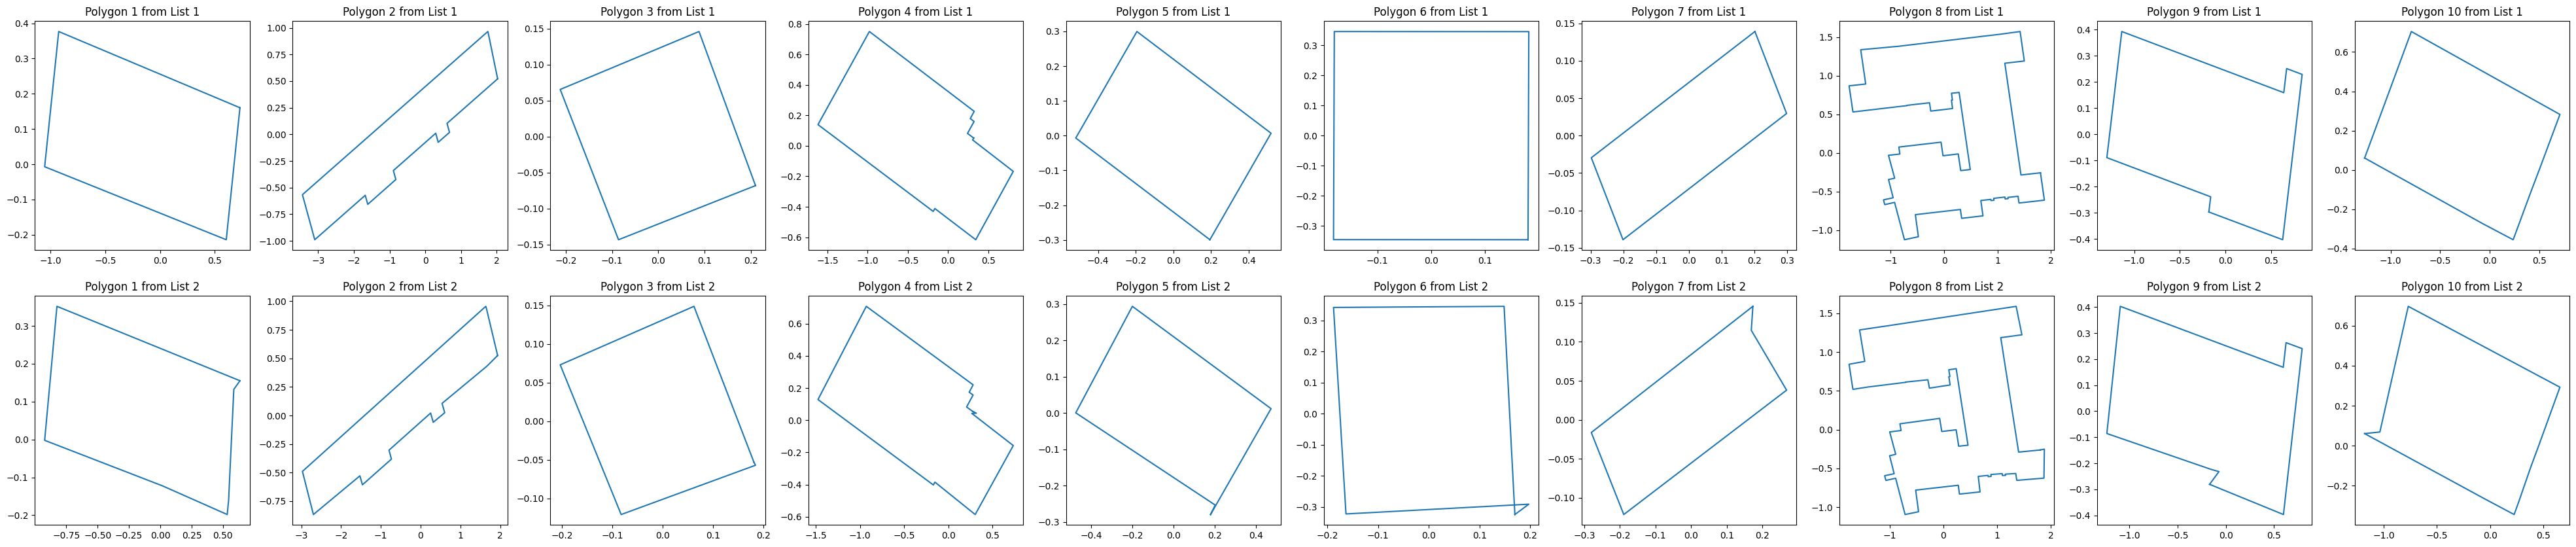

In [11]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

show_tokens = val_tokens[:10]

pae.eval()
with torch.no_grad():
    show_hidden, show_outputs, _ = pae(show_tokens)

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in show_tokens]
new_polygons = [reverse_vector_polygon(token) for token in show_outputs]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)

# Show the plot
plt.show()

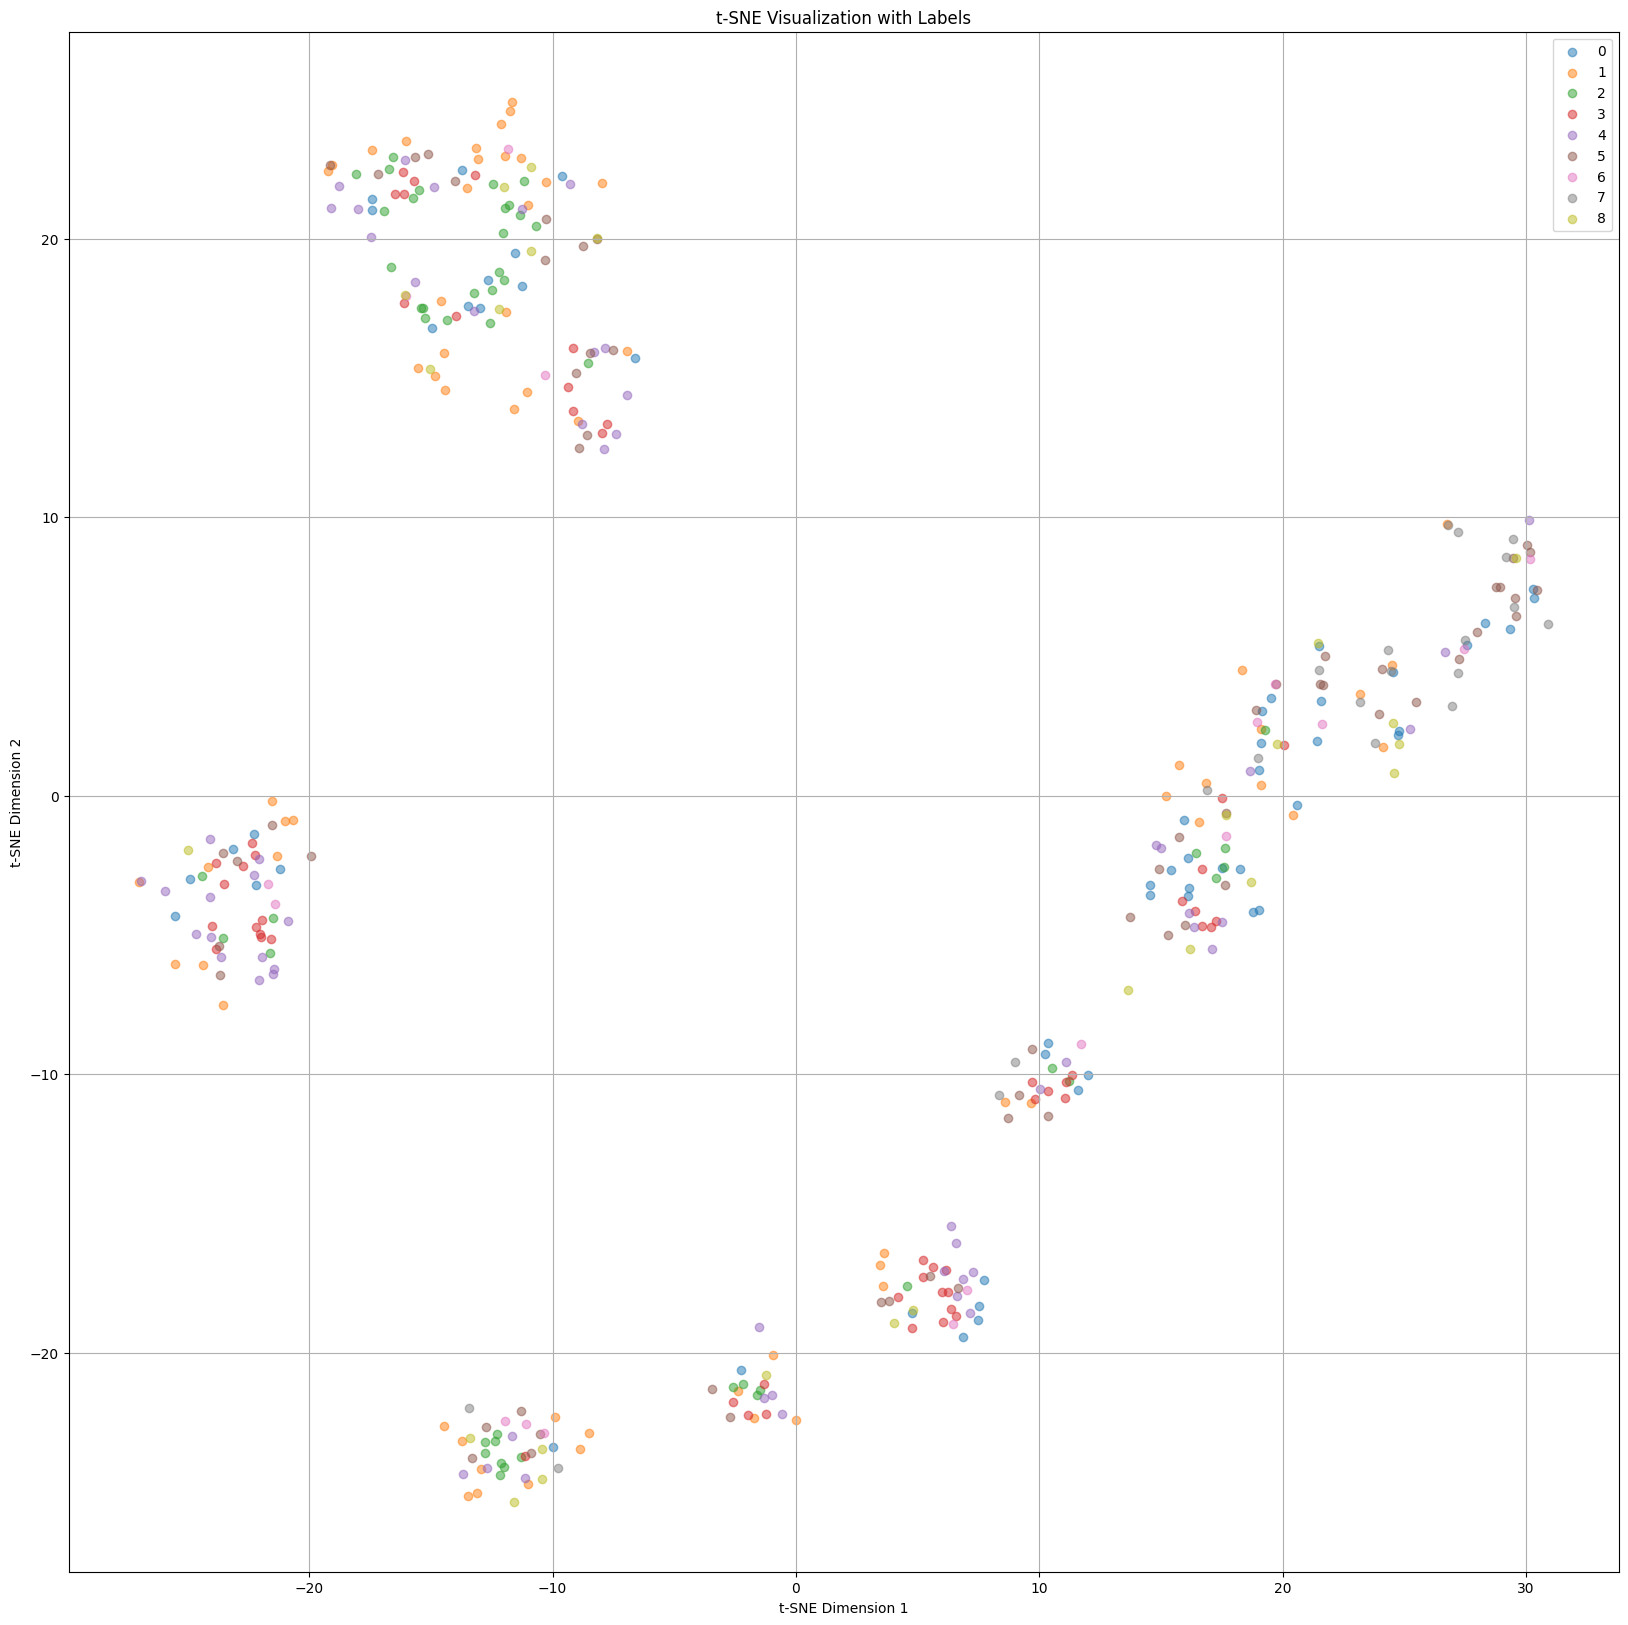

In [24]:
hidden = val_hidden.view(val_hidden.size(0), -1)

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(hidden)

plt.figure(figsize=(20, 20))

# Plot each class separately
for label in np.unique(val_labels):
    indices = val_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# with torch.no_grad():
#     train_hidden = pae(train_tokens)[0].view(train_tokens.size(0), -1)
#     val_hidden = pae(val_tokens)[0].view(val_tokens.size(0), -1)

train_hidden = train_tokens.view(train_tokens.size(0), -1)
val_hidden = val_tokens.view(val_tokens.size(0), -1)

train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=32, shuffle=True)

In [30]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)
        return x
    
classifier = Classifier(train_hidden.size(1), 128, 9, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=0.004)
optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 100

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, train_loader)
    val_loss, val_acc = evaluate(classifier, val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 2.0488330125808716, Train Acc 0.18, Val Loss: 2.030149221420288, Val Acc: 0.1775
Epoch: 2, Train Loss: 1.9936548614501952, Train Acc 0.205625, Val Loss: 2.029181957244873, Val Acc: 0.1975
Epoch: 3, Train Loss: 1.9571596384048462, Train Acc 0.229375, Val Loss: 2.094268798828125, Val Acc: 0.205
Epoch: 4, Train Loss: 1.9395980167388915, Train Acc 0.249375, Val Loss: 2.0485479831695557, Val Acc: 0.21
Epoch: 5, Train Loss: 1.9040007519721984, Train Acc 0.26375, Val Loss: 2.011514663696289, Val Acc: 0.2425
Epoch: 6, Train Loss: 1.8595245051383973, Train Acc 0.291875, Val Loss: 1.9981637001037598, Val Acc: 0.2875
Epoch: 7, Train Loss: 1.8160452508926392, Train Acc 0.31625, Val Loss: 1.9903985261917114, Val Acc: 0.255
Epoch: 8, Train Loss: 1.7891129112243653, Train Acc 0.325625, Val Loss: 1.990267276763916, Val Acc: 0.2375
Epoch: 9, Train Loss: 1.7631847953796387, Train Acc 0.34125, Val Loss: 2.0058553218841553, Val Acc: 0.265
Epoch: 10, Train Loss: 1.7484313464164734, Tr